<a href="https://colab.research.google.com/github/EFluet/alos_gee/blob/master/GEE_ALOS_Wetland_v10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Wetland detection with multi-temporal ALOS L-Band HH-polarized imagery.
*Etienne Fluet-Chouinard, Stanford University, 2019* 

**ALOS imagery:** This analysis uses ALOS L-band scenes preprocessed by ASF that were ingested into GEE. The image collection contains all Fine-Beam Single (FBS) and Fine-Beam Dual (FBD). The scenes are radiometrically-terrain corrected (RTC) at a 30-m resolution.

**Training data:** Training polygons sampled from the National Wetland Inventory; reclassified based on water regime attribute. The ROI was filtered to be a section of NWI whose photo-interpreted imagery was between 2006-2010.

**Analysis steps:**

1. Classify wetland/upland mask

    a. Apply Sigma-Lee Speckle filter to individual ALOS images [(Lee et al. 2008)](https://ieeexplore.ieee.org/document/4689358);  *TODO: Does it need updating for 16-look SAR?*
      
    b.  Compute harmonic regressions of time-series of *ALOS-HH, Landsat7-EVI & NDWI*; summarizing the time-series into three parameters: mean, amplitude, phase.
    
    c. Stack harmonic parameters of: *ALOS-HH, EVI, NDWI* with other static predictors: *SRTM Elevation & Slope% Tree Cover*
    
    d. Make spatial-cluster based on harmonic parameters; uses SNIC clustering method.
    
    e. Create stratified sample of training points over NWI wetland polygons (an upland).
    
    f. Train Random Forest models (n=10) on training sample.
       
    g. Predict wetland/upland mask across the ROI.


2. Classify individual scene as inundated/dry.

  a. TODO: Correct σ<sup>0</sup>(θ) σ0(θ<sub>ref</sub>) to account for linear shift in backscatter per vegetation cover type [(see Schlaffer et al. 2016)](https://www.mdpi.com/2072-4292/8/5/402)

  b. TODO: Correct for the effect of tree cover on mean SAR backscatter. *Is this necessary for the wetland masking?* 
  
  c. TODO: Define a wet/dry threshold using a unsupervised clustering (*k=2*) on paired wetland & upland pixels, binned by % Tree Cover  and  EVI (to account for aboveground biomass).

  d. **TODO: Update masking of thresholded output.**

  e. **TODO: Make stratified sample of TCP & EVI for RF & thresholding.**
  e2. **TODO: Stratified sample: no. of points per classes proportional to their relative occurence (i.e. matching area of each bin).**

  f. **TODO: Use TensorFlow instead of RF.**
  f2. **TODO: OR make loop of % accuracy decrease.**

  g. DONE: Add clip to the ALOS function to preserve geometry.

  h. DONE: Fix the joining of ALOS & EVI filtered that creates additional images between of overlapping images taken on the same day.  Assign image index of alos to EVI, then make the join on the image index rather than the datetime.**

  i. **TODO: Exclude urban areas, radar shadows & open water from 

  j. **cloud mask of 8-day EVI? **



*This analysis is translated in-part from my JavaScript code here:*
https://code.earthengine.google.com/a8083be26bb9cd13b287aeb21524bb3f


[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/googlecolab/colabtools/blob/master/notebooks/colab-github-demo.ipynb)

# 0 -Initialize notebook
- Install python packages to notebook.
- Authorize Earth Engine and Drive.

In [1]:
#%%bash
!pip install -U -q earthengine-api
!pip install -U -q folium
!pip install -U -q git+https://github.com/mccarthyryanc/folium_gee.git
!pip install -U -q pandas
!pip install -U -q geopandas
!pip install -U -q matplotlib
# !pip install statsmodels -Us
!pip install -U -q geetools

     |████████████████████████████████| 153kB 8.9MB/s 
     |████████████████████████████████| 92kB 5.7MB/s 
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.10.1 which is incompatible.
     |████████████████████████████████| 921kB 7.5MB/s 
     |████████████████████████████████| 11.8MB 66.8MB/s 
     |████████████████████████████████| 10.1MB 57.5MB/s 
     |████████████████████████████████| 81kB 6.2MB/s 
     |████████████████████████████████| 225kB 26.6MB/s 


In [2]:
from google.colab import auth
auth.authenticate_user()

from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [4]:
# First run authentication, then copy to the last line
# !earthengine authenticate --quiet
!earthengine authenticate --authorization-code=4/uAE3E6bM6Y1YoCyqin_HZnOhZp8kdJkxlBII06sOzrlm9glQPsTM8_g

# Trigger the authentication flow.
# ee.Authenticate()

Running command using Cloud API.  Set --no-use_cloud_api to go back to using the API


Successfully saved authorization token.


In [5]:
import ee; ee.Initialize() # Import the Earth Engine API and initialize it.
import folium
# Import the Folium library.
# Fixed here: https://gis.stackexchange.com/questions/342022/trouble-plotting-earth-engine-images-with-folium-using-python
import foliumgee   # Test with: !earthengine upload image -h
import pandas as pd
import geopandas as gpd
import numpy as np
from pandas.api.types import CategoricalDtype
import matplotlib.pyplot as plt

from plotnine import *
# import altair as alt
import pandas as pd
import numpy as np

from geetools import tools


%automagic ON
%matplotlib inline
# shell commands in notebook are executed in a temporary subshell. 
# To change the wd in a more enduring way, use the %cd magic command.
# print(folium.__version__) # print(foliumgee.__version__)


Automagic is ON, % prefix IS NOT needed for line magics.


# 1 - Read inputs

### ROI & NWI polygon features
- Polygon for the state of Florida from which ASF image downloads were made: fl_polygon
- NWI multipart polygons aggregated by water regime code.

### ALOS Image Collection (1707 over Florida)
- Band 1: Backscatter Sigma-naught (in DN) 
- Band 2: Incidence angle (in rad)
- Band 3: Layer mask

## 1.1 - Landsat ancillary: Landsat RGB, Tree %, EVI

In [6]:
# Change wd to location in Google Drive #!cd ~/my_drive/Colab\ Notebooks
%cd /content/gdrive/My\ Drive/Colab\ Notebooks     
#!pwd

%ls # List content of dir

%run get_nwi_roi.py # Get nwi_roi with .py script

%run get_preds.py # Get preditors with .py script: ALOS, EVI, NDWI, SRTM

# print(alos.first().geometry().getInfo())

/content/gdrive/My Drive/Colab Notebooks
'Copy of GEE ALOS Wetland v10'   old/
 fcn_folium_gee.py               old_colabs/
 fcns_extract_to_df.py           __pycache__/
 folium_map_predictors.py        sigma_lee_filter.py
'GEE ALOS Wetland v10'           strat_pts_extract_alos_tcp_evi_26nov2019.csv
 get_nwi_roi.py                  strat_pts_extract_alos_tcp_evi_3dec2019.csv
 get_preds.py                    strat_pts_extract_alos_ts2.csv
 harmonic_model.py               tutorials/
got to the end


## 1.2 - Get extraction function
- *Problem is that importing function as a module causes problems with import ee not being recognized.* 

In [0]:
# Add drive dir to sys path
import sys
sys.path.append('/content/gdrive/My\ Drive/Colab\ Notebooks/')

#import fcns_extract_to_df  # import my modules

%run fcns_extract_to_df
# cat fcns_extract_to_df.py  # to print script code. 

# 2 - Pre-proceess predictors

## 2.1 - Sigma-Lee Speckle Filter

In [0]:
# Get functiton: Sigma-Lee speckle filter: based on https://code.earthengine.google.com/2ef38463ebaf5ae133a478f173fd0ab5
%run sigma_lee_filter.py

# /------------------------------------------------------------------#
#/ Make function that preps ALOS collection
def apply_filter(image):

  image = image.select('sigma0');
  image = toDB(RefinedLee(toNatural(image)));
  image = image.reproject('EPSG:4326', None, 30)\
               .set('system:time_start', image.get('system:time_start'));
  return(image);

# /------------------------------------------------------------------------#
#/ Apply Lee-Sigma speckle filter
# alos_filt = alos.filterDate('2010-01-01', '2010-03-29');
alos_filt = alos.map(apply_filter);   # .select(['sum'],['b1']); # Select 2 bands

# Reduce to median
alos_median = alos.reduce(ee.Reducer.median());
alos_filt_median = alos_filt.reduce(ee.Reducer.median());

## 2.2 - Harmonic model

In [0]:
# Get harmonic model function
# TODO: Find a way to rescale values avg & amplitude; between 0-1? 
%run harmonic_model.py

#-------------------------------------------------------------------------
# run harmonic model on Filtered ALOS data
hm_filt_sar = harmonic_model(alos_filt, 'sum', 1, roi);

# Make RGB image from output
hm_filt_sar_rgb = ee.Image.cat(hm_filt_sar.select('sin_1'),
                               hm_filt_sar.select('cos_1'),
                               hm_filt_sar.select('sum_mean')).hsvToRgb();

#-------------------------------------------------------------------------
# run harmonic model on EVI
hm_evi = harmonic_model(evi, 'EVI', 1, roi);

# Make RGB image from output
hm_evi_rgb = ee.Image.cat(hm_evi.select('sin_1'),
                          hm_evi.select('cos_1'),
                          hm_evi.select('EVI_mean')).hsvToRgb();

#-------------------------------------------------------------------------
# run harmonic model on Filtered ALOS data
hm_ndwi = harmonic_model(ndwi, 'NDWI', 1, roi);

# Make RGB image from output
hm_ndwi_rgb = ee.Image.cat(hm_ndwi.select('sin_1'),
                           hm_ndwi.select('cos_1'),
                           hm_ndwi.select('NDWI_mean')).hsvToRgb();

## 2.3 - Stack predictors as bands

In [0]:
# Select the bands for training
bands = ['phase_sar','ampl_sar','avg_sar',
         'phase_ndwi','ampl_ndwi','avg_ndwi',
         'phase_evi','ampl_evi','avg_evi',
         'TREE','ELEV', 'SLOPE'];

# Make stack of predictors
pred_stack = hm_filt_sar.addBands(hm_evi)\
                 .addBands(hm_ndwi)\
                 .addBands(tree_cov_perc)\
                 .addBands(srtm_elev)\
                 .addBands(srtm_slope)\
                 .rename(bands)\
                 .reproject('EPSG:4326', None, 30);

## 2.4 - SNIC segmentation

In [0]:
# This has global geometry... TODO: Clip the pred stack to the union of geometries
# // Compute the union, display it in magenta:   union = poly1.union(poly2, ee.ErrorMargin(1));
pred_stack_snic = ee.Algorithms.Image.Segmentation.SNIC(**{'image': pred_stack, 
                                                'size': 8,         # Spacing of seeds in nb. pixels 
                                                'compactness': 2,  # Larger values cause clusters to be more compact (square). Setting this to 0 disables spatial distance weighting.
                                                'connectivity': 8, # Either 4 or 8.
                                                'neighborhoodSize':256,
                                                })\
                              .reproject('EPSG:4326', None, 30);

## 2.5 - Export stack as Asset
**TODO: fix region export for all of florida.**

In [0]:
if 1 == 0:

  from geetools import tools
  # None of these work
  # print(fl.geometry().getInfo());
  # region = ee.Geometry.Rectangle([-87.8, 25, -72.75, 31.15], None, False);

  # Note:  It looks like a multipolygon cannot be used as a region for export
  # This worked for square ROI polygon;
  region = tools.geometry.getRegion(roi)

  # Create a task : export the result as image asset
  task = ee.batch.Export.image.toAsset(image= pred_stack_snic,
                                        description="Predictors SNIC roi",
                                        assetId="users/etiennefluet/pred_stack_snic_roi",
                                        scale=30,
                                        region= region, # fl.geometry().getInfo(),
                                        )
  task.start()

# 3 - Make wetland/upland mask

## 3.1 - Make stratified sample
Sample points in NWI polygon. 
- Currently stratified by water regime class, but should be instead stratified by TCP & EVI bins
- Make stratified by bin: 10 TCP * 10 EVI * 2 NWI = 200 bins


#### 3.1.1 - Make bins from real values

In [0]:
### Make image of bin codes FROM  REAL VALUES !!!
## TODO: Fix the stratified samble because hm_snic_mean data may not be scaled entirely to the seems alter valuto 
## ANSWER:  The range of values of the HM-average outputs is modified from inputs: for instance hm_average_sar has min:101, max:126. 
## TODO2: Make Optimum allocation: sampling fraction of each stratum is proportionate to both the proportion and the standard deviation of the variable. 
# Mod on 2 Dec 2019: 


# Function that bins image with limits, gives numeric 1,2,..,n bin labels.
def bin_numlabel(image, limits):
  b= ee.ImageCollection.fromImages(ee.List(limits).map(lambda limit: image.gt(ee.Number(limit))));
  b = b.sum()
  return(b)

# Convert NWI to 2 classes, adding the 2 classes as 'mask' band.
wetmask = nwi_poly_img.remap([0,1,2,3,4],[0,1,1,1,1])
nwi_poly_img = nwi_poly_img.addBands(wetmask).select(['class','remapped'],['class','mask'])
nwi_bins = nwi_poly_img.select('mask').multiply(100 * 100 * 100);

#-------------------------------------------------------------------------------
# Bin SAR
limits = np.arange(-50, 51, 10).tolist()
print('SAR bin limits: ', limits)
# sar_hm_snic = pred_stack_snic.select('avg_sar_mean')
alos_filt_median_clipped = alos_filt_median.clip(roi)
sar_bins =  bin_numlabel(alos_filt_median_clipped, limits)

#-------------------------------------------------------------------------------
# Bin TCP
limits = np.arange(0, 101, 10).tolist()
print('TCP bin limits: ', limits)
tcp_hm_snic = tree_cov_perc.select('tree_canopy_cover_median').clip(roi)
tcp_bins =  bin_numlabel(tcp_hm_snic, limits)
tcp_bins = tcp_bins.multiply(100)

#-------------------------------------------------------------------------------
# Bin EVI
limits = [round(i,1) for i in np.arange(0, 1.01, 0.1).tolist()] 
print('EVI bin limits: ', limits)
evi_hm_snic = pred_stack_snic.select('avg_evi_mean')
evi_hm_snic_bins =  bin_numlabel(evi_hm_snic, limits).multiply(100 * 100)

#-------------------------------------------------------------------------------
# Add bins together and rename
comb_bins = sar_bins.add(tcp_bins)\
                    .add(evi_hm_snic_bins)\
                    .add(nwi_bins)\
                    .select(['sum_median'],['bins'])\
                    .clip(roi.geometry());

#-------------------------------------------------------------------------------
# Make stack of predictors
comb_bins_n_pred_stack_snic = comb_bins.addBands(pred_stack_snic)\
                                  .addBands(nwi_poly_img.select(['mask']))\
                                  .reproject('EPSG:4326', None, 30);
# .rename(bands)\



#----------------------------------------------------------------------------------
# Make stratified sample based on training set of sample points.
# This works when working from the saved asset SNIC 
# TODO:  Make the number of points per classes representative of their relative occurence (i.e. matching area of each bin)
train_pts = pred_n_training.stratifiedSample(**{
      'numPoints':  1,
      'classBand': 'bins',
      'projection': 'EPSG:4326',
      'scale': 30,        
      'tileScale': 2, 
      'region': roi,
      'seed': int(np.random.randint(low=1, high=100, size=1)),
      'geometries': True })

# Get tree cover %
pred_n_training_ex = pred_n_training.clip(train_pts)

# Query aborterd error wheen trying to print (getInfo) 5000+ elements...
x = extract_pt_singleimg(pred_n_training_ex, train_pts)

# Print length of bins
print(len(x.bins.unique()))

SAR bin limits:  [-50, -40, -30, -20, -10, 0, 10, 20, 30, 40, 50]
TCP bin limits:  [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
EVI bin limits:  [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
40


#### 3.1.2 - Export bin & predictors.

In [0]:
#-------------------------------------------------------------------------------
if 0 == 1:

  from geetools import tools

  # Note:  It looks like a multipolygon cannot be used as a region for export
  # This worked for square ROI polygon;
  region = tools.geometry.getRegion(roi)

  # Create a task : export the result as image asset
  task = ee.batch.Export.image.toAsset(image= comb_bins_n_pred_stack_snic,
                                        description="comb_bins_n_pred_stack_snic",
                                        assetId="users/etiennefluet/comb_bins_n_pred_stack_snic",
                                        scale=30,
                                        region=region,)
  task.start()

### 3.1.2B - reread the exported layer

In [0]:
#-------------------------------------------------------------------------------
# Many images do not intersect with the points in the roi, so that's why sometime can get more 
# solution is to make point per tile.
pred_n_training = ee.Image('users/etiennefluet/comb_bins_n_pred_stack_snic')

#### 3.1.3 - Stratify sample of real value bins.

In [9]:
#----------------------------------------------------------------------------------
# ptsperbin = int( 5000 / len(df2['count']) ) / 2
ptsperbin = 20

# Make actual sampling
train_pts = pred_n_training.stratifiedSample(**{
      'numPoints':  ptsperbin,
      'classBand': 'bins',
      'projection': 'EPSG:4326',
      'scale': 30,        
      'tileScale': 2, 
      'region': roi,
      'seed': int(np.random.randint(low=1, high=100, size=1)),
      'geometries': True })


print('Number of pts in stratified sample: ', train_pts.size().getInfo())

### Extract stratified point values
# out = extract_pt_singleimg(sar_bins, test_strat_pts)
# out

# ## select & rename columns
# out = out[['pt_id', 'mean']]
# out = out.rename(columns={"mean": "nwi_bin"})

Number of pts in stratified sample:  546


#### Unused - FreqHistogram of Random Sample 

In [0]:
# TO GET RANDOMLY SAMPLED BIN AREA;  
# FOR AREA PROPORTIONAL STRATIFIED SAMPLING; OR ESTIMATE VARIANCE IN EACH BIN
# THIS CAN GO HIGHER THAN 5000 POINTS IF DRAWN FROM A SAVED IMAGE; OTHERWISE GETS MEMORY LIMIT ERROR

# Get the list of bin values from the random sample
n = 500  # number of random points to generate
fg_points = ee.FeatureCollection.randomPoints(roi, n, 0, 5);
# fg_points = train_pts

frequency = pred_n_training.reduceRegions(**{'reducer': ee.Reducer.frequencyHistogram(), 
                                      'collection': fg_points, 
                                      'scale': 30});

vals0 = fc2df(frequency) # convert to dataframe

import pandas as pd
from pandas.io.json import json_normalize
df2 = json_normalize(vals0['histogram'])

if 'pt_id' not in df2:
  df2.index.name = 'pt_id'        # make column from rowname; can only run once
  df2.reset_index(inplace=True)   # remove row index
  df2 = df2.rename_axis(None)  # Remove the rowname header

df2 = df2.melt('pt_id', var_name='bins', value_name='count')#.dropna(thresh=1) #.drop('variable', 1)
df2 = df2.dropna(subset=['count']) # Remove NaN counts
df2 = df2.groupby('bins').agg(count = pd.NamedAgg(column='count', aggfunc=sum))

print('number of unique bins: ', len(df2['count']))
# df2

## 3.2 - Train Random Forests & Predict
Produces a wetland/upland mask.

In [0]:
# Re-Read the exported again, for faster plotting
# OMG!!! DRAWING FROM SAVED IMAGES VS IN-MEMORY CAN PREVENT MOMEOLY LIMITS!
pred_stack_snic = ee.Image('users/etiennefluet/pred_stack_snic')

# Appends _mean to each band name, to match new SNIC band names
bands_snic = [s + '_mean' for s in bands]

# Sample predictor values at point locations. 
train_pts_wpred =  pred_n_training.select(bands_snic)\
                              .addBands(nwi_poly_img)\
                              .sampleRegions(**{
                                        'collection': train_pts,    # The regions/pts to sample over.
                                        'properties': ['mask'],     # The list of properties to copy from each input feature.
                                        'scale': 30,                # A nominal scale in meters of the projection to sample in.
                                        'tileScale': 16              
                              });


# # Train random forest 'outOfBagMode': True
trained = ee.Classifier.randomForest(**{'numberOfTrees': 10, 'bagFraction': 0.5 })\
                           .train(train_pts_wpred, "mask", bands_snic);

# # Apply classifier to image stack
classified = pred_n_training.select(bands_snic).classify(trained);
print(classified.getInfo())

{'type': 'Image', 'bands': [{'id': 'classification', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': -2147483648, 'max': 2147483647}, 'dimensions': [2784, 2321], 'crs': 'EPSG:4326', 'crs_transform': [0.0002694945852358564, 0, -81.8748804459203, 0, -0.0002694945852358564, 27.500574950392966]}], 'properties': {'system:footprint': {'type': 'LinearRing', 'coordinates': [[-81.87482054091879, 26.874951141445084], [-81.87477095865599, 26.87494275422968], [-81.6872448467832, 26.87494279189893], [-81.4997439976239, 26.874942776306955], [-81.3122431424924, 26.874942803777017], [-81.12474247565126, 26.8749428192594], [-81.12460284632786, 26.875052465491702], [-81.12443965055736, 26.875151537522903], [-81.12443788309227, 27.500440215740646], [-81.12456152138678, 27.50056451486157], [-81.12466655907603, 27.500701662211405], [-81.12471663709125, 27.500710107157495], [-81.3122431424924, 27.50071019897389], [-81.49974399762388, 27.500710206605234], [-81.6872448467832, 27.500710157478682]

In [0]:
# Sample predictor values at point locations
train_pts_wpred =  pred_n_training.select(bands_snic)\
                              .addBands(nwi_poly_img)\
                              .sampleRegions(**{'collection': train_pts,
                                                'properties': ['mask'],
                                                'scale': 30,
                                                'tileScale': 2 });             
# Train random forest 
trained = ee.Classifier.randomForest(**{'numberOfTrees': 1, 'bagFraction': 0.5 })\
                          .train(train_pts_wpred, "mask", bands_snic);

print('trained')
# resubstitution accuracy --------------------------------------------
confMat = trained.confusionMatrix();

outrow = {'sub_accuracy': trained.confusionMatrix().accuracy().getInfo(),
      'sub_kappa': trained.confusionMatrix().kappa().getInfo()}

outrow
outrow

trained


## 3.2 - Predictor importance loop

In [27]:
#----------------------------------------------------------------------------------
def get_metric_dic(train_pts, val_pts, pred_n_training, bandlist):

  # Sample predictor values at point locations
  train_pts_wpred =  pred_n_training.select(bandlist)\
                                .addBands(nwi_poly_img)\
                                .sampleRegions(**{'collection': train_pts,
                                                  'properties': ['mask'],
                                                  'scale': 30,
                                                  'tileScale': 2 });             
  # Train random forest 
  trained = ee.Classifier.randomForest(**{'numberOfTrees': 1, 'bagFraction': 0.5 })\
                            .train(train_pts_wpred, "mask", bandlist);


  # resubstitution accuracy --------------------------------------------
  confMat = trained.confusionMatrix();
  # print('  - got confusion matrix')

  # Independent accuracy -----------------------------------
  classified = pred_n_training.select(bandlist).classify(trained);

  # Valid pt sampling of predictor values at point locations. 
  val_pts_wpred =  pred_n_training.select(bandlist)\
                                .sampleRegions(**{'collection': val_pts,
                                                  'properties': ['mask'],
                                                  'scale': 30,
                                                  'tileScale': 2  });         

  # Classify the validation data.
  validated = val_pts_wpred.classify(trained);

  # Get a confusion matrix representing expected accuracy.
  errMat = validated.errorMatrix('mask', 'classification');

  # print('  - got error matrix')

  # Append rows to Empty Dataframe by adding dictionaries
  outrow = {'sub_accuracy': trained.confusionMatrix().accuracy().getInfo(),
            'sub_kappa': trained.confusionMatrix().kappa().getInfo(),
            'ind_accuracy':errMat.accuracy().getInfo(),
            'ind_kappa':errMat.kappa().getInfo()}


  return(outrow)

#----------------------------------------------------------------------------------
# Mean decrease in accuracy
def accuracy_loop(train_pts, val_pts, pred_n_training, bandlist):

  # Create empty output df
  acc_df = pd.DataFrame(columns=['sub_accuracy', 'sub_kappa','ind_accuracy','ind_kappa'])

  #-----------------------------------------------------------------------------
  # Run for full mode
  outrow = get_metric_dic(train_pts, val_pts, pred_n_training, bandlist)
  outrow.update( {'band':'fullmodel'} ) # Adding a new key value pair
  acc_df = acc_df.append(outrow, ignore_index=True)

  #-----------------------------------------------------------------------------
  # For subset (k-1) accuracy; Loop through each band
  for band in bandlist:

    # copy the list
    subset_bandlist= bandlist.copy() 

    # Exclude one band from the list
    subset_bandlist.remove(band)

    print('excluding: ', band)
    print('keeping: ', subset_bandlist)

    # Get metrics
    outrow = get_metric_dic(train_pts, val_pts, pred_n_training, subset_bandlist)

    # Adding a new key value pair
    outrow.update( {'band':band} )

    # Append the row to df 
    acc_df = acc_df.append(outrow, ignore_index=True)

  return(acc_df)



#----------------------------------------------------------------------------------

# Make training set of sample points; Replace this with stratification by bins
val_pts = pred_n_training.stratifiedSample(**{
      'numPoints':  20,
      'classBand': 'mask',
      'projection': 'EPSG:4326',
      'scale': 30,        
      'tileScale': 2, 
      'region': roi,
      'seed': int(np.random.randint(low=1, high=100, size=1)),
      'geometries': True })


# Select the bands for training
bands = ['phase_sar','ampl_sar','avg_sar',
         'phase_ndwi','ampl_ndwi','avg_ndwi',
         'phase_evi','ampl_evi','avg_evi',
         'TREE','ELEV', 'SLOPE'];

bands_snic = [s + '_mean' for s in bands]


#----------------------------------------------------------------------------------
# Run function
# get_metric_dic(train_pts, val_pts, pred_n_training, bands_snic)
acc_df = accuracy_loop(train_pts, val_pts, pred_n_training, bands_snic)

acc_df

KeyboardInterrupt: ignored

## 3.4 - Get independent accuracy

In [0]:
# Make training set of sample points.
# Replace this with stratification by bins
val_pts = nwi_poly_img.stratifiedSample(**{
      'numPoints':  4000,
      'classValues': [0, 1, 2, 3, 4],
      'classPoints': [2000, 500, 500, 500, 500],
      'classBand': 'mask', #'class',
      'projection': 'EPSG:4326',
      'scale': 30,        
      'tileScale': 2, 
      'region': roi,
      'seed': int(np.random.randint(low=1, high=100, size=1)),
      'geometries': True }).filter(ee.Filter.neq('mask', None));


# Sample predictor values at point locations. 
val_pts_wpred =  pred_stack_snic.select(bands_snic)\
                              .addBands(nwi_poly_img)\
                              .sampleRegions(**{
                                        'collection': val_pts,      # The regions/pts to sample over.
                                        'properties': ['mask'],     # The list of properties to copy from each input feature.
                                        'scale': 30,                # A nominal scale in meters of the projection to sample in.
                                        'tileScale': 2  });         # Scaling factor reducing aggregation tile size; larger tileScale (e.g. 2 or 4) may enable oom computations with default.


# Classify the validation data.
validated = val_pts_wpred.classify(trained);
# print(validated)

# Get a confusion matrix representing expected accuracy.
errMat = validated.errorMatrix('mask', 'classification');
# print('Validation error matrix: ', errMat.getInfo());
print('RF Val. accuracy: ', errMat.accuracy().getInfo());
print('RF Val. kappa: ', errMat.kappa().getInfo());

## 3.5 - Make difference raster
To visually assess locations of: TP, FP, FN, TN.

In [0]:
# Make difference raster
diff = classified.gt(0).add(nwi_poly_img.gt(0).select('mask').multiply(10))

# Remove 0 value
diff = diff.updateMask(diff.gt(0));

print(diff.getInfo())

{'type': 'Image', 'bands': [{'id': 'classification', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 11}, 'dimensions': [2784, 2321], 'crs': 'EPSG:4326', 'crs_transform': [0.0002694945852358564, 0, -81.8748804459203, 0, -0.0002694945852358564, 27.500574950392966]}]}


#### 3.6 - Profile wetland mask error

By evaluating the average conditions of FP, FN.

# Figure - Map of predictors & classified output

In [0]:
# Import the Folium library.
# Fixed here: https://gis.stackexchange.com/questions/342022/trouble-plotting-earth-engine-images-with-folium-using-python
import folium

# Define a method for displaying Earth Engine image tiles to folium map.
def add_ee_layer(self, eeImageObject, visParams, name):
  map_id_dict = ee.Image(eeImageObject).getMapId(visParams)
  folium.raster_layers.TileLayer(
    tiles = map_id_dict['tile_fetcher'].url_format,
    attr = "Map Data &copy; <a href='https://earthengine.google.com/'>Google Earth Engine</a>",
    name = name,
    overlay = True,
    control = True
  ).add_to(self)

# Add EE drawing method to folium.
folium.Map.add_ee_layer = add_ee_layer

# Create a folium map object.
myMap = folium.Map(location=[27.1, -81.4], 
                 zoom_start=14,
                 height=600, width=1000,
                 #tiles='Stamen Terrain', 
                 control_scale=True, detect_retina=False)

#-----------------------------------------------------------------------
# Make symbols for Landsat 7 
visParams = {'bands': ['B3', 'B2', 'B1'], 'min': 0, 'max': 0.3}
myMap.add_ee_layer(l7sr, visParams, 'Landsat7')

#-------------------------------------------------------------------------------
# Add original ALOS imagery.
# visParams = {'bands': ['sigma0_median'], 'min': -50, 'max': 20}
# myMap.add_ee_layer(alos_median, visParams, 'ALOS median')

#-------------------------------------------------------------------------------
# Add ALOS scene count
# visParams = {'min':-20, 'max':50, 'bands': ['b1'], 'palette': ['white','green']}
# myMap.add_ee_layer(alos.count(), visParams, 'alos count')


#-------------------------------------------------------------------------------
# NWI BINS
# visParams = {'bands': ['sum_median'], 'min': 0, 'max': 10, 'palette': ['white', 'purple']}
# myMap.add_ee_layer(sar_bins, visParams, 'sar_bins')

#-------------------------------------------------------------------------------
# BINS
# visParams = {'bands': ['bins'], 'min': 0, 'max': 11111111, 'palette': ['green', '#ffa500', 'purple', 'blue']}
# myMap.add_ee_layer(comb_bins, visParams, 'comb_bins')


#-------------------------------------------------------------------------------
# Add filtered ALOS imagery.
visParams = {'bands': ['sum_median'], 'min': -50, 'max': 20}
myMap.add_ee_layer(alos_filt_median, visParams, 'ALOS filter median')


#-------------------------------------------------------------------------------
# Filtered SAR seasonality RGB

# Make RGB image from output
hm_snic_sar_rgb = ee.Image.cat(pred_stack_snic.select('phase_sar_mean'),
                               pred_stack_snic.select('ampl_sar_mean'),
                               pred_stack_snic.select('avg_sar_mean')).hsvToRgb();

visParams = {'bands': ['red', 'green', 'blue'], 'min': 0, 'max': 1}
myMap.add_ee_layer(hm_filt_sar_rgb, visParams, 'ALOS Seasonality RGB')

#-------------------------------------------------------------------------------
# NWI symbols
nwi_poly_img_mskd = nwi_poly_img.updateMask(nwi_poly_img.gt(0))  # mask upland=0
visParams = {'bands': ['mask'], 'min':1, 'max':4,              'palette': ['green', '#ffa500', 'purple', 'blue']}
myMap.add_ee_layer(nwi_poly_img_mskd, visParams, 'NWI polygons')


#-------------------------------------------------------------------------------
# Classified output
classified_mskd = classified.updateMask(classified.gt(0))  # mask upland=0
visParams = {'bands': ['classification'], 'min':0, 'max':4, 
             'palette': ['white', 'green', '#ffa500', 'purple', 'blue']}
myMap.add_ee_layer(classified_mskd, visParams, 'Classified')


#-------------------------------------------------------------------------------
# Difference map;   values are: 1, 10, 11
# Red is FP (commission error)
# Orange is FN (ommission error)
# Green is TP
visParams = {'min':1, 'max':11, 'bands': ['classification'], 
             'palette': ['red','orange','orange','orange','orange','orange','orange','orange','orange','orange','green']}
myMap.add_ee_layer(diff, visParams, 'Difference')

#-------------------------------------------------------------------------------
# plot stratified point sample
fc = ee.FeatureCollection(train_pts, "geometry")
train_pts_img = ee.Image().byte().paint(train_pts, "class").reproject('EPSG:4326', None, 30);
myMap.add_ee_layer(train_pts_img, {'palette': '#ff00e6'}, 'train_pts_img')

#-------------------------------------------------------------------------------
myMap.add_child(folium.LayerControl())  # Add a layer control panel to the map.
display(myMap)  # Display the map.

# 4 - Make ImgCollec of predictors

## 4.1 - Filter EVI to match ALOS dates
EVI is originally on a 8-day composite.

**TODO:** Filter EVI to 2006-2011 earlier to reduce memory.

In [0]:
# Function that filters image collection to within a window of ALOS dates. 
# Take median if multiple image within window.
# Returns image with 0 bands if there is no match for the filter.
# https://gis.stackexchange.com/questions/327904/combine-two-image-collections-into-one-image-collection-earth-engine
# https://gis.stackexchange.com/questions/273676/merging-two-image-collection-into-one-with-two-bands-lst-and-ndvi
def date_filter(alosimage, ndays, coll2filter):

    # get date of ALOS image
    alosdate = ee.Date(alosimage.get('system:time_start'));
    
    # Filter Landsat images by date 
    evi_sel = coll2filter.filterDate(alosdate.advance(-14, 'day'), alosdate.advance(14, 'day'));
    
    # Clip images to those overlapping the alos image
    evi_sel = evi_sel.filterBounds(alosimage.geometry());

    # Get median of Landsat images; in case multiple are found.
    # Set timestamp to that of ALOS image.
    evi_sel = evi_sel.median()\
                    .set('system:time_start', alosimage.get('system:time_start'))\
                    .set('system:index', alosimage.get('system:index'));

    # Clip the image (this one changes the geometry)
    # Nov28 - The geometries of ALOS & EVI_filtered are the same now. 
    evi_sel = evi_sel.clip(alosimage.geometry());
    
    # Mask EVI based on ALOS data (to remove wedges between square bbox and tilted scene border)
    evi_sel = evi_sel.updateMask(alosimage.select(['sigma0']).gte(-99999999));

    return(evi_sel);

In [29]:
# Re read the ALOS collection because its geometry gets lost during the 'prep_alos' function.
# Maybe a fix here: https://gis.stackexchange.com/questions/328693/gee-error-provide-geometry-parameter-when-aggregating-over-an-unbounded-image
# alos = ee.ImageCollection("users/etiennefluet/fl_aug31");
# CURRENTLY THIS RETURNS A COLLECTION WITHOUT ANY NAME...
# Could this be because the initial window of 1 day never returned an image?


# Map function through EVI image collection.
evi_filtered = alos.map(lambda i: date_filter(i, 10, evi));

# Attempt to return name of band
evi_filtered = evi_filtered.map(lambda i: i.rename(['EVI']));


#-------------------------------------------------------------------------------
print('alos collection size', alos.size().getInfo());
print('alos collection bands', alos.first().bandNames().getInfo());

print('evi_collection size', evi.size().getInfo());
print('evi_collection bands', evi.first().bandNames().getInfo());

print('Filtered evi_collection size', evi_filtered.size().getInfo());
print('Filtered evi_collection bands', evi_filtered.first().bandNames().getInfo());

alos collection size 0.675
alos collection bands ['sigma0', 'incangle']
evi_collection size 276
evi_collection bands ['EVI']
Filtered evi_collection size 1707
Filtered evi_collection bands ['EVI']


## 4.2 - Make ImgColl of ALOS, EVI & TCP

To then apply the masking & threshold

Based on: https://developers.google.com/earth-engine/joins_inner

In [30]:
# Solution 2:  Calculate area of each polygon :  
# print('Polygon area: ', boulder.area().divide(1000 * 1000));
#           Then filter the images based on area.

# Collections
mod1 = alos #.select('b1')
mod2 = evi_filtered #.select('EVI')
evi_filtered

d1=ee.Date.fromYMD(2009,1,1)
d2=ee.Date.fromYMD(2009,6,1)
# # filter collections to date range (no longer needed)
mod1 = mod1.filterDate(d1, d2)
mod2 = mod2.filterDate(d1, d2)

# Use an equals filter to define how the collections match.
# Filtering on the ALOS index (transferred during the window averaging)
# return a 1:1 join, while using time_start retunns many. 
filterTimeEq = ee.Filter.equals(**{'leftField' : 'system:index',
                                   'rightField': 'system:index'});

# filterTimeEq = ee.Filter.equals(**{'leftField' : 'system:time_start',
#                                    'rightField': 'system:time_start'});

# Create the join.
innerJoin = ee.Join.inner('primary', 'secondary');

# Inner join
innerJoined = ee.ImageCollection(innerJoin.apply(mod1, mod2, filterTimeEq))

# Map a function to merge the results in the output FeatureCollection.
joined_alos_evi = innerJoined.map(lambda feature: ee.Image.cat(feature.get('primary'), feature.get('secondary')));

#--------------------------------------------------------------------
print('No. images in ALOS collection:', mod1.size().getInfo());
print('No. images in filtered EVI collection:', mod2.size().getInfo());
print('No. images in Joined collection:', joined_alos_evi.size().getInfo());
print('joined band name:', joined_alos_evi.first().bandNames().getInfo());

No. images in ALOS collection: 111
No. images in filtered EVI collection: 111
No. images in Joined collection: 111
joined band name: ['sigma0', 'incangle', 'EVI']


# 5 - Extract backscatter values
Could look into using geextract: http://www.loicdutrieux.net/landsat-extract-gee/index.html#

## 5.1 - Extract predictor collection at points
- Problem:  Cannot access the image id of the joined EVI & ALOS image.
- The reason I want to run the poitn extraction is that it would avoid running it twice, separately for EVI & ALOS.
- Exporting the joined collection would likely work, but it would duplicate data and take too long.

See resource: # Other trail of investigation: https://khufkens.com/2017/07/22/google-earth-engine-time-series-subset-tool/


In [31]:
points = train_pts
alos = alos.filterBounds(points)


# # Convert from DN to dB by applying function over the collection
# alos = ee.ImageCollection("users/etiennefluet/fl_aug31")\
#               .map(lambda i: prep_alos(i))\
#               .map(apply_filter)\
#               .select(['sum'],['b1'])\
#               .filterBounds(points);

# Run extraction; 
# takes 37sec for each with 5800 pts per bin
# took 16sec/image this time...
%prun df_all = extract_pt_loop(alos, 'users/etiennefluet/fl_aug31/', points)

# Remove NA backscatter
df_all = df_all[df_all.b1.notnull()]

### Force values to numeric 
df_all.b1= pd.to_numeric(df_all.b1, errors='coerce')
df_all.b2= pd.to_numeric(df_all.b2, errors='coerce')
# df_all.b3= pd.to_numeric(df_all.b3, errors='coerce')

# Convert ms timestamp to date-time
# This should be modified to produce YYYY-MM-DD-hh-mm-ssZ format
df_all['date'] = pd.to_datetime(df_all['date'], unit='ms') 

# Because the conversion was only applied to the collection, not individual images.
# df_all['b1'] = np.log10(df_all['b1'])*10
# Convert inc.angle from radians to degrees
df_all['b2'] = np.log10(df_all['b2'])*180/3.1415926535

# df_all.head(5)

# Other extract from: https://developers.google.com/earth-engine/python_install

In [32]:
evi_filtered_bnds = evi_filtered.filterBounds(points)

# Extract EVI at points
evi_x = extract_pt_loop(evi_filtered_bnds, 'users/etiennefluet/fl_aug31/', points)


# TODO:  Figure out why there are 3 columns... seems like b1 is EVI, but need to make sure.
evi_x2 = evi_x[['pt_id', 'b1', 'date']]  # select columns

# rename columns
evi_x2 = evi_x2.rename(columns={"b1": "evi"})

# Convert ms timestamp to date-time
evi_x2['date'] = pd.to_datetime(evi_x2['date'], unit='ms') 

evi_x2 = evi_x2[evi_x2.evi.notnull()]
evi_x2.loc[evi_x2.evi > 1, 'evi'] = 1

# Plot EVI values
# evi_x2['evi'].sample(n=50000).plot.hist()
# evi_x2['evi'].min()

ValueError: ignored

## 4.4 - Extract Tree Cover %

In [0]:
# Get tree cover %
tree_cov_perc_bnds = tree_cov_perc.clip(points)

# Query aborterd error wheen trying to print (getInfo) 5000+ elements...
tcp = extract_pt_singleimg(tree_cov_perc_bnds, points)

# select columns
tcp = tcp[['pt_id', 'mean']]
# rename columns
tcp = tcp.rename(columns={"mean": "tcp"})

## 4.6 - Join and save point extraction to Drive

In [0]:
# Join ALOS & TreeCover% data extracted on pt_id
df_all2 = pd.merge(df_all, tcp, how='outer', on=['pt_id'])

# If EVI is filtered:  Join on both pt_id & date, since the EVI datestamp matches the one from ALOS.
df_all2 = pd.merge(df_all2, evi_x2, how='outer', on=['pt_id','date'])

# remove rows with NaN for tcp & evi
df_all2= df_all2[df_all2.tcp.notnull()]
df_all2= df_all2[df_all2.evi.notnull()]

# Save joined df to drive
df_all2.to_csv('strat_pts_extract_alos_tcp_evi_5dec2019.csv')  

In [35]:
df_all2.columns

Index(['pt_id', 'ELEV_mean', 'SLOPE_mean', 'TREE_mean', 'ampl_evi_mean',
       'ampl_ndwi_mean', 'ampl_sar_mean', 'avg_evi_mean', 'avg_ndwi_mean',
       'avg_sar_mean', 'b1', 'b2', 'b3', 'bins', 'clusters', 'mask',
       'phase_evi_mean', 'phase_ndwi_mean', 'phase_sar_mean', 'seeds',
       'geometry', 'geometrytype', 'date', 'tcp', 'evi'],
      dtype='object')

# 5- Cluster γ0 per vegetation bin
Make df with each row a bin, then loop through bins to subset extracted data and calculate the threshold.

In [36]:
# Re-Read the CSV
# df = pd.read_csv('strat_pts_extract_alos_tcp_evi_26nov2019.csv')  
df = df_all2

tcp_binlim = np.arange(0,  101,  10).tolist()
evi_binlim = np.arange(0, 1.01, 0.1).tolist()

# Cut values into bins, as new columns. 
df['tcp_cut'] = pd.cut(df.tcp, bins=tcp_binlim, labels=list(range(0, 10)))
df['evi_cut'] = pd.cut(df.evi, bins=evi_binlim, labels=list(range(0, 10)))
df['evi_cut'] = df['evi_cut'].apply(lambda x: x*1000)

# Convert 
df['evi_cut_num'] = pd.to_numeric(df.evi_cut, errors='coerce')
df['tcp_cut_num'] = pd.to_numeric(df.tcp_cut, errors='coerce')
df['label'] = df['tcp_cut_num'].add(df['evi_cut_num'])

# Make column of lower & upper limit of bins. The labels are set as the lower limit
df['tcp_lowerLim'] = pd.cut(df.tcp, bins=tcp_binlim, labels=np.arange(0,   99, 10).tolist())
df['tcp_upperLim'] = pd.cut(df.tcp, bins=tcp_binlim, labels=np.arange(10, 101, 10).tolist())

df['evi_lowerLim'] = pd.cut(df.evi, bins=evi_binlim, labels=np.arange(0, 0.99, 0.1).tolist())
df['evi_upperLim'] = pd.cut(df.evi, bins=evi_binlim, labels=np.arange(0.1, 1.01, 0.1).tolist())

# Reclassify the NWI water regime as upland/wetland: class_rgrp
# df.loc[df['class'].isin([1,2,3,4]), 'class_rgrp'] = 1
# df.loc[df['class'].isin([0]), 'class_rgrp'] = 0

# Set weights for the ROC
df['weights'] = np.where(df['mask'] == 0,  0.2, 0.8)

print(df.columns)

Index(['pt_id', 'ELEV_mean', 'SLOPE_mean', 'TREE_mean', 'ampl_evi_mean',
       'ampl_ndwi_mean', 'ampl_sar_mean', 'avg_evi_mean', 'avg_ndwi_mean',
       'avg_sar_mean', 'b1', 'b2', 'b3', 'bins', 'clusters', 'mask',
       'phase_evi_mean', 'phase_ndwi_mean', 'phase_sar_mean', 'seeds',
       'geometry', 'geometrytype', 'date', 'tcp', 'evi', 'tcp_cut', 'evi_cut',
       'evi_cut_num', 'tcp_cut_num', 'label', 'tcp_lowerLim', 'tcp_upperLim',
       'evi_lowerLim', 'evi_upperLim', 'weights'],
      dtype='object')


In [37]:
# Make df of unique value combination
comb = df.groupby(['tcp_cut','evi_cut','label']).size().reset_index()

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp

# Get best threshold 
def Find_Optimal_Cutoff(target, predicted, weights=None):
  fpr, tpr, threshold = roc_curve(target, predicted)
  if weights is not None:
    fpr, tpr, threshold = roc_curve(target, predicted, sample_weight=weights)
  i = np.arange(len(tpr)) 
  roc = pd.DataFrame({'tf' : pd.Series(tpr+(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
  roc_t = roc.ix[(roc.tf-0).abs().argsort()[:1]]
  return(roc_t)

# Create empty columns
comb['npos'] = np.nan
comb['tf'] = np.nan
comb['threshold'] = np.nan

#-------------------------------------------------------------------------------
# Loop through rows, representing bins of TCP & EVI
for index, row in comb.iterrows():

    # Subset the pt data to match the current bin
    t = df[(df['tcp_cut']== row['tcp_cut']) & (df['evi_cut']== row['evi_cut'])]  

    # To test that weights do anything, replace the 1st weight in each loop.
    # t.iloc[0, t.columns.get_loc('weights')] = 1000

    # if the subset is not empty, and has both classes
    if (sum(t['mask']>0) and int(sum(t['mask'])) < len(t['mask'])):

      # print('sum y_true: ' + str(int(sum(t['mask']))) + ' / ' + str(len(t['mask'])))

      # calculate roc curve
      c = Find_Optimal_Cutoff(t['mask'], t['b1'], t['weights'])

      # Add values to df
      comb['npos'][index] = int(sum(t['mask']))
      comb['tf'][index] = c.iloc[0,0]
      comb['threshold'][index] = c.iloc[0,1]


comb = comb.rename(columns={0: "n"}) # rename columns

# Remove rows with NaN threhsold; maybe make this a 2nd version.
comb =comb[comb.threshold.notnull()]

# Join the thresholds back onto the points dataframe. 
df = pd.merge(df, comb, how='left', on=['tcp_cut','evi_cut'])

# Apply threshold, by making binary classification. 
df['classified'] = np.where(df['b1'] >= df['threshold'], 1, 0)



# 11/21/2019- Filtering with Query should be faster but didnt get it to work. 
# t = df_all2.query("{0} == '{1}' & {2} == '{3}'".format("tcp_cut", row['tcp_cut'], "evi_cut", row['evi_cut']))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be

## Figure - Bin Heatmaps

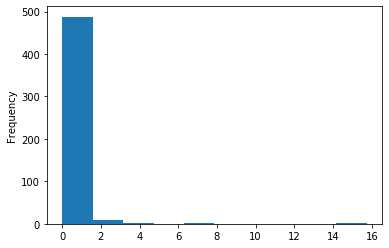

In [42]:
df['b1'].sample(n=500).plot.hist()

/usr/local/lib/python3.6/dist-packages/plotnine/scales/scale.py:93: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(self.breaks) and cbook.iterable(self.labels):
/usr/local/lib/python3.6/dist-packages/plotnine/utils.py:553: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  return cbook.iterable(var) and not is_string(var)


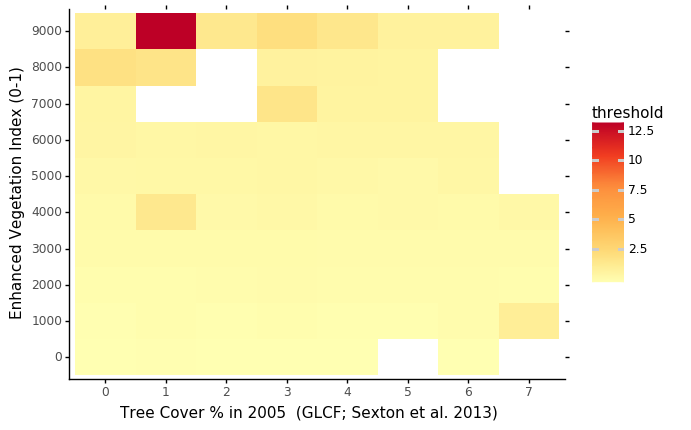

<ggplot: (8745016763389)> 

/usr/local/lib/python3.6/dist-packages/plotnine/utils.py:553: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  return cbook.iterable(var) and not is_string(var)


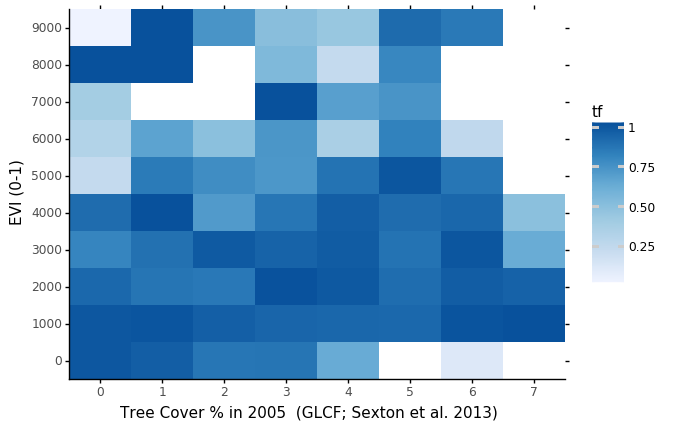

<ggplot: (-9223363291838035982)> 

/usr/local/lib/python3.6/dist-packages/plotnine/utils.py:553: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  return cbook.iterable(var) and not is_string(var)


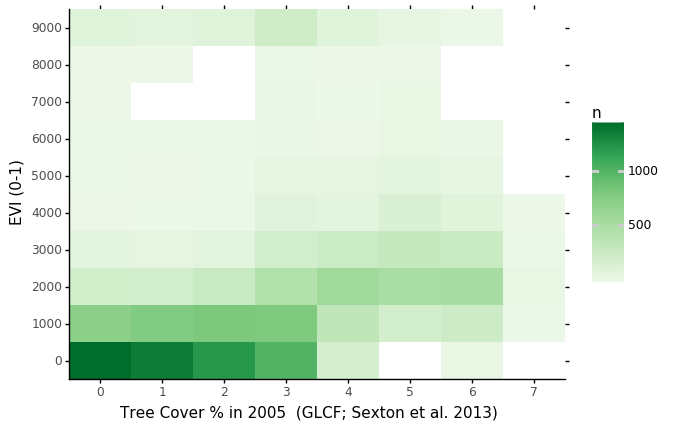

<ggplot: (8745016716748)>


In [38]:
# Heatmap of threshold value. 
thresh_plot = (ggplot(comb)
 + geom_tile(aes(x='tcp_cut', y='evi_cut', fill='threshold'))
 + theme_classic() 
#  + scale_x_discrete(expand=[0,0]) 
#  + scale_y_discrete(expand=[0,0])
 + scale_fill_distiller(palette='YlOrRd')
 + xlab("Tree Cover % in 2005  (GLCF; Sexton et al. 2013)")  
 + ylab("Enhanced Vegetation Index (0-1)"))

#-----------------------------------------------------------------------
# Heatmap of treshold No. points
tf_plot = (ggplot(comb)
 + geom_tile(aes(x='tcp_cut', y='evi_cut', fill='tf'))
 + theme_classic() 
 + scale_x_discrete(expand=[0,0]) 
 + scale_y_discrete(expand=[0,0])
 + scale_fill_distiller(palette='Blues')
 + xlab("Tree Cover % in 2005  (GLCF; Sexton et al. 2013)")  
 + ylab("EVI (0-1)"))

#-----------------------------------------------------------------------
# Heatmap of No. points
n_plot = (ggplot(comb)
 + geom_tile(aes(x='tcp_cut', y='evi_cut', fill='n'))
 + theme_classic() 
 + scale_x_discrete(expand=[0,0]) 
 + scale_y_discrete(expand=[0,0])
 + scale_fill_distiller(palette='Greens')
 + xlab("Tree Cover % in 2005  (GLCF; Sexton et al. 2013)")  
 + ylab("EVI (0-1)"))


# Prints plots in the same cell.
print(thresh_plot, tf_plot, n_plot)

In [0]:
# 2D scatterplot of thresholded values 
(ggplot(df)
 + geom_point(aes(x='tcp', y='b1', color='classified', group='pt_id'), size=2.5)
 #+ facet_wrap(facets ='class', nrow=1)
 + theme_classic() 
#  + scale_x_continuous(expand=[0,0]) 
#  + scale_y_continuous(expand=[0,0])
 + scale_color_distiller(type='div', palette='Spectral')
 + xlab("Tree Cover % in 2005   (GLCF; Sexton et al. 2013)")  
 + ylab("ALOS HH backscatter   (gamma-naught)")
 + theme(axis_text_x=element_text(rotation=45, hjust=1)))

## Figure - 3D scatterplot 

In [40]:
import plotly.express as px
import plotly.graph_objects as go

fig = go.Figure()

fig = px.scatter_3d(df, x='tcp', y='evi', z='b1',
                    # color= 'class_rgrp',
                    color= 'classified',
                    symbol='mask',
                    color_continuous_scale=px.colors.sequential.Pinkyl)

fig.update_layout(scene = dict(
                    xaxis_title='Tree Cover % <br> (GLCF; Sexton et al. 2013)',
                    yaxis_title='Enhanced Vegetation Index <br> (EVI; Landsat8)',
                    zaxis_title='γ<sub>0-HH</sub> ALOS backscatter (dB)'),
                    width=700,
                    margin=dict(r=20, b=10, l=10, t=10))

fig.update_traces(marker=dict(size=4, line=dict(width=1, color='DarkSlateGrey')),
                  selector=dict(mode='markers'))

fig.show()

# For color palettes: https://plot.ly/python/plotly-express/

## 5.1 - Apply dry/wet threshold to each image

## 5.3 - Apply threshold to images

In [0]:
#-------------------------------------------------------------------------------
# Second attempt: Make a threshold raster
def customRemap(image, tcp_Limits, evi_Limits):

  # Get ALOS & EVI bands
  tcp_band  = tree_cov_perc.clip(image.geometry())
  alos_band = image.select('b1') #.log10().multiply(10)
  evi_band  = image.select('EVI')

  # Remap (with limits) TCP & EVI to ranges, making numeric labels
  tcp_reclass = ee.ImageCollection.fromImages(ee.List(tcp_Limits).map(lambda limit: tcp_band.gt(ee.Number(limit)))).sum();
  evi_reclass = ee.ImageCollection.fromImages(ee.List(evi_Limits).map(lambda limit: evi_band.gt(ee.Number(limit)))).sum();

  # Make image of bin code, from pandas cut numeric labels TCP * 1,000 + EVI
  bins_codes = tcp_reclass.multiply(1000).add(evi_reclass);

  # Remap numeric labls into threshold values
  bins_threshold = bins_codes.remap(comb['label'].tolist(), 
                                    comb['threshold'].tolist())

  bins_threshold = bins_threshold.subtract(10)

  # Mask to wetlands (from prev step)
  thresholded = alos_band.gt(bins_threshold)
  thresholded = thresholded.unmask(0)

  return(thresholded) # return thresholded image


#-------------------------------------------------------------------------------

image = joined_alos_evi #.first()
tcp_Limits = np.arange(0, 1.01, 0.1).tolist()
evi_Limits = np.arange(0, 101, 10).tolist()

# remaped = customRemap(joined_alos_evi.first(), tcp_Limits, evi_Limits)

remaped_coll = joined_alos_evi.map(lambda i: customRemap(i, tcp_Limits, evi_Limits));

# Sum number of inundated scenes
inund_sum = remaped_coll.sum()

# Mask out areas at 0
#inund_sum = inund_sum.updateMask(inund_sum.gt(0));


# inund_sum = inund_sum.updateMask(nwi_poly_img.select(['mask']));


# Clip to ROI
inund_sum = inund_sum.clip(roi);

# Mask out classified upland
# Mask out urban areas
# Mask out terrain radar shadow

# Figure - Map of filtered, Join & Thresholded

In [0]:
# Import the Folium library.
# Fixed here: https://gis.stackexchange.com/questions/342022/trouble-plotting-earth-engine-images-with-folium-using-python
import folium

# Define a method for displaying Earth Engine image tiles to folium map.
def add_ee_layer(self, eeImageObject, visParams, name):
  map_id_dict = ee.Image(eeImageObject).getMapId(visParams)
  folium.raster_layers.TileLayer(
    tiles = map_id_dict['tile_fetcher'].url_format,
    attr = "Map Data &copy; <a href='https://earthengine.google.com/'>Google Earth Engine</a>",
    name = name,
    overlay = True,
    control = True
  ).add_to(self)

# Add EE drawing method to folium.
folium.Map.add_ee_layer = add_ee_layer

# Create a folium map object.
myMap = folium.Map(location=[27.1, -81.4], 
                 zoom_start=14,
                 height=600, width=1000,
                 #tiles='Stamen Terrain', 
                 control_scale=True, detect_retina=False)

#-----------------------------------------------------------------------
# Make symbols for Landsat 7 
visParams = {'bands': ['B3', 'B2', 'B1'], 'min': 0, 'max': 0.3}
myMap.add_ee_layer(l7sr, visParams, 'Landsat7')

# #-------------------------------------------------------------------------------
# # WHY DID THIS CHANGE AFTER THE JOIN? IT SHOULDN'T BE AFFECTED...
# visParams = {'min':0, 'max':1, 'bands': ['EVI'], 'palette': ['black','red']}
# myMap.add_ee_layer(evi_filtered.first(), visParams, 'evi_filtered')

# #-------------------------------------------------------------------------------
# visParams = {'min':-30, 'max':20, 'bands': ['b1'],  'palette': ['black','green']}
# myMap.add_ee_layer(alos.first(), visParams, 'alos')

# #-------------------------------------------------------------------------------
# visParams = {'min':0, 'max':1, 'bands': ['EVI'],  'palette': ['yellow','purple']}
# myMap.add_ee_layer(joined_alos_evi.first(), visParams, 'evi joined')

# #-------------------------------------------------------------------------------
# # THE JOINED ALOS IS BLANK WHEN USING ALOS_FILT.  BECAUSE NO GEOM?
# # This is fixed when not using 
# # visParams = {'min':0, 'max':100, 'bands': ['b1'],  'palette': ['white','black']}
# # myMap.add_ee_layer(joined_alos_evi.count(), visParams, 'alos joined')

# #-------------------------------------------------------------------------------
# # ALOS
# # visParams = {'min':-9999999, 'max':999999, 'bands': ['b1'],  'palette': ['yellow','orange','red','purple','blue','green']}
# # myMap.add_ee_layer(joined_alos_evi.first(), visParams, 'alos joined first')

# #-------------------------------------------------------------------------------
# visParams = {'min':0, 'max':1, 'bands': ['b1'],  'palette': ['blue','red']}
# myMap.add_ee_layer(remaped, visParams, 'alos joined first')

# #-------------------------------------------------------------------------------
# visParams = {'min':0, 'max':1010, 'bands': ['b1'],  'palette': ['yellow','orange', 'pink']}
# myMap.add_ee_layer(bins_codes, visParams, 'bins_codes')

# #-------------------------------------------------------------------------------
# visParams = {'min':-10, 'max':10, 'bands': ['remapped'],  'palette': ['yellow','orange', 'red']}
# myMap.add_ee_layer(bins_threshold, visParams, 'bins_threshold')

#-------------------------------------------------------------------------------
# visParams = {'min':0, 'max':1, 'bands': ['b1'],  'palette': ['pink','purple']}
# myMap.add_ee_layer(thresholded, visParams, 'thresholded')

#-------------------------------------------------------------------------------
visParams = {'min':0, 'max':30, 'bands': ['b1'],  'palette': ['yellow','orange','red','#8b0000']}
myMap.add_ee_layer(inund_sum, visParams, 'inund_sum')


#-------------------------------------------------------------------------------
myMap.add_child(folium.LayerControl()) # Add a layer control panel to the map.
display(myMap) # Display the map.

# 6 - Compare hydroperiod to NWI water regime
Quick&Dirty version: sum the number
Sequentially going through the dates, use lag in the df; calculate the length of time that is estimated as inundated


# 7 - Compare inundated area to SWAMPS-GLWD

# Bakwass!

In [0]:
# Import the Folium library.
# Fixed here: https://gis.stackexchange.com/questions/342022/trouble-plotting-earth-engine-images-with-folium-using-python
import folium

# Define a method for displaying Earth Engine image tiles to folium map.
def add_ee_layer(self, eeImageObject, visParams, name):
  map_id_dict = ee.Image(eeImageObject).getMapId(visParams)
  folium.raster_layers.TileLayer(
    tiles = map_id_dict['tile_fetcher'].url_format,
    attr = "Map Data &copy; <a href='https://earthengine.google.com/'>Google Earth Engine</a>",
    name = name,
    overlay = True,
    control = True
  ).add_to(self)

# Add EE drawing method to folium.
folium.Map.add_ee_layer = add_ee_layer

# Create a folium map object.
myMap = folium.Map(location=[27.1, -81.4], 
                 zoom_start=14,
                 height=600, width=1000,
                 #tiles='Stamen Terrain', 
                 control_scale=True, detect_retina=False)

#-------------------------------------------------------------------------------
visParams = {'min':0, 'max':10, 'bands': ['tree_canopy_cover_median'],  'palette': ['white','yellow','orange','red']}
myMap.add_ee_layer(tcp_bins, visParams, 'tcp_bins')


#-------------------------------------------------------------------------------
visParams = {'min':0, 'max':10, 'bands': ['evi'], 'palette': ['white','green']}
myMap.add_ee_layer(evi_bins, visParams, 'evi_bins')


#-------------------------------------------------------------------------------
# Add a layer control panel to the map.
myMap.add_child(folium.LayerControl())

# Display the map.
display(myMap)

### Plot backscatter density
Using plotnine (the equivalent of ggplot2)
- Another great resource for Collab figures: https://colab.research.google.com/notebooks/charts.ipynb#scrollTo=N-u5cYwpS-y0
- Intro to Altair: https://colab.research.google.com/drive/19fssNGwuhenT6BPvC2ZCND_4NrKdcTdV#scrollTo=LhYR8yfAt0ni

## Plot backscatter time-series

Objective:  Correct effect of incidence on backscatter, accounting for 1) Tree Cover, 2) Phenology (EVI), 3) Vegetation type (biome)

Steps:
- Find pixels that have minimal change in EVI between two dates.
- Get backscatter and incidence angle over these areas/periods.
- Fit linear model per LC class.

Threshold as flooded / non-flooded:
- Mask by each LC category, mask by bin of EVI.
- For each bin, run unsupervised clustering on GEE.

In [0]:
(ggplot(df_all2)
 + geom_point(aes(x='date_x', y='b1', color='tcp', group='pt_id'), size=0.5)
 + geom_line(aes(x='date_x', y='b1', color='tcp', group='pt_id'), size=0.5)
 # + facet_wrap(facets ='class', nrow=5)
 + theme_classic() 
 + scale_x_datetime(expand=[0,0]) + scale_y_continuous(expand=[0,0])
 + xlab("sigma0 HH backscatter")  + ylab("Backscatter") +
 theme(axis_text_x=element_text(rotation=45, hjust=1))
)

(ggplot(df_all2)
 + geom_point(aes(x='date_x', y='b1', color='tcp', group='pt_id'), size=0.5)
 + geom_line(aes(x='date_x', y='b1', color='tcp', group='pt_id'), size=0.5)
 + facet_wrap(facets ='class', nrow=1)
 + theme_classic() 
 + scale_x_datetime(expand=[0,0]) + scale_y_continuous(expand=[0,0])
 + xlab("sigma0 HH backscatter")  + ylab("Backscatter") +
 theme(axis_text_x=element_text(rotation=45, hjust=1))
)

## Plot Gamma_0 ~ Incidence Angle ~ Tree Cover

In [0]:
(ggplot(df_all2)
 + geom_point(aes(x='tcp', y='b1', color='class', group='pt_id'), size=0.5)
 #+ facet_wrap(facets ='class', nrow=1)
 + theme_classic() 
 + scale_x_continuous(expand=[0,0]) + scale_y_continuous(expand=[0,0])
 + xlab("Tree Cover % in 2005   (GLCF; Sexton et al. 2013)")  
 + ylab("ALOS HH backscatter   (gamma-naught)")
 + theme(axis_text_x=element_text(rotation=45, hjust=1))
)

In [0]:
# Make composite by stacking images

# Select the bands for training
var bands = ['SAR','EVI', 'ELEV', 'SLOPE','TREE',
              'phase_sar','ampl_sar','avg_sar',
              'phase_ndwi','ampl_ndwi','avg_ndwi',
              'phase_evi','ampl_evi','avg_evi'];


// Example of how to do it with iterate:  https://gis.stackexchange.com/questions/254722/how-to-stack-bands-in-google-earth-engine
// Combine images as bands of a composite. 
var stacked_composite = alos_sigma0_hh.addBands(srtm_elev)
                                      .addBands(srtm_slope)
                                      .addBands(evi)
                                      .addBands(treeCanopyCover)
                                      .addBands(seasonality_sar)
                                      .addBands(seasonality_ndwi)
                                      .addBands(seasonality_evi)
                                      .rename(bands)
                                      .reproject('EPSG:4326', null, 30);


In [0]:
#----------------------------------------------------------------------------------
### SUPPLANTED BY BETTER APPROACH!!!!!!!
# Make random points to get the bin values 
# There is a risk here that not all bins are represented
# To sample class values, since not all bin combination exists. 
n = 5000  # number of random points to generate
fg_points = ee.FeatureCollection.randomPoints(roi, n, 0, 5);

# Get the list of bin values from the random sample
freqHist = comb_bins.reduceRegions(**{'reducer': ee.Reducer.frequencyHistogram(), 
                                      'collection': fg_points, 
                                      'scale': 30});

# Get unique values: # https://gis.stackexchange.com/questions/322081/finding-all-the-values-within-a-band-in-google-earth-engine
def flatten_dict(feat):
  feat = ee.Feature(feat)
  vals = ee.Dictionary(feat.get('histogram')).keys();
  return(ee.Feature(None, {'vals': vals}))



In [0]:
#----------------------------------------------------------------------------------
# Make random points to get the bin values 
# There is a risk here that not all bins are represented
# To sample class values, since not all bin combination exists. 

n = 5  # number of random points to generate
fg_points = ee.FeatureCollection.randomPoints(roi, n, 0, 5);

# Get the list of bin values from the random sample
freqHist = comb_bins.reduceRegions(**{'reducer': ee.Reducer.frequencyHistogram(), 
                                      'collection': fg_points, 
                                      'scale': 30});

# Get unique values: # https://gis.stackexchange.com/questions/322081/finding-all-the-values-within-a-band-in-google-earth-engine
def flatten_dict(feat):
  feat = ee.Feature(feat)
  vals = ee.Dictionary(feat.get('histogram')).keys();
  return(ee.Feature(None, {'vals': vals}))  #  Get the counts too?

# # Rewrite the dictionary into a list
values = ee.List(freqHist.map(lambda feat: flatten_dict(feat)).aggregate_array('vals')).flatten().distinct();
classvalint = [int(i) for i in values.getInfo()] # Convert the class values to int

print('Bins values: ', classvalint);
# print('Number of bins: ', len(values.getInfo()));

#### Not Used - Stratification from SNIC bins (range of val is wrong)

In [0]:
# #----------------------------------------------------------------------------------
# # Make random points to get the bin values 
# # There is a risk here that not all bins are represented
# # To sample class values, since not all bin combination exists. 
# n = 5000  # number of random points to generate
# fg_points = ee.FeatureCollection.randomPoints(roi, n, 0, 5);

# # Get the list of bin values from the random sample
# freqHist = comb_bins.reduceRegions(**{'reducer': ee.Reducer.frequencyHistogram(), 
#                                       'collection': fg_points, 
#                                       'scale': 30});

# # Get unique values: # https://gis.stackexchange.com/questions/322081/finding-all-the-values-within-a-band-in-google-earth-engine
# def flatten_dict(feat):
#   feat = ee.Feature(feat)
#   vals = ee.Dictionary(feat.get('histogram')).keys();
#   return(ee.Feature(None, {'vals': vals}))

# # Rewrite the dictionary into a list
# values = ee.List(freqHist.map(lambda feat: flatten_dict(feat)).aggregate_array('vals')).flatten().distinct();
# classvalint = [int(i) for i in values.getInfo()] # Convert the class values to int

# print('Bins values: ', classvalint);
# print('Number of bins: ', len(values.getInfo()));

In [0]:
### Make image of bin codes FROM SAVE SNIC IMAGES!!!
## TODO: Fix the stratified samble because hm_snic_mean data may not be scaled entirely to the seems alter valuto 
## TODO2: Make Optimum allocation: sampling fraction of each stratum is proportionate to both the proportion and the standard deviation of the variable. 


#----------------------------------------------------------------------------------


# Convert NWI to 2 classes
wetmask = nwi_poly_img.remap([0,1,2,3,4],[0,1,1,1,1])
nwi_poly_img = nwi_poly_img.addBands(wetmask).select(['class','remapped'],['class','mask'])
nwi_bins = nwi_poly_img.select('mask').multiply(1000 * 1000 * 1000);


# Bin SAR
limits = np.arange(-50, 51, 10).tolist()
print(limits)
sar_hm_snic = pred_stack_snic.select('avg_sar_mean')
sar_hm_snic_bins = ee.ImageCollection.fromImages(ee.List(limits).map(lambda limit: sar_hm_snic.gt(ee.Number(limit)))).sum();

# Bin TCP
limits = np.arange(0, 101, 10).tolist()
print(limits)
tcp_hm_snic = pred_stack_snic.select('TREE_mean')
tcp_hm_snic_bins = ee.ImageCollection.fromImages(ee.List(limits).map(lambda limit: tcp_hm_snic.gt(ee.Number(limit)))).sum();
tcp_hm_snic_bins = tcp_hm_snic_bins.multiply(1000);

# Bin EVI
limits = [round(i,1) for i in np.arange(0, 1.01, 0.1).tolist()] 
print(limits)
evi_hm_snic = pred_stack_snic.select('avg_evi_mean')
evi_hm_snic_bins = ee.ImageCollection.fromImages(ee.List(limits).map(lambda limit: evi_hm_snic.gt(ee.Number(limit)))).sum();
evi_hm_snic_bins = evi_hm_snic_bins.multiply(1000 * 1000);

# Add bins together and rename
comb_bins = sar_hm_snic_bins.add(tcp_hm_snic_bins).add(evi_hm_snic_bins).add(nwi_bins);  
comb_bins = comb_bins.select(['avg_sar_mean'],['bins']);

#----------------------------------------------------------------------------------
# Make stratified sample based on training set of sample points.
# This works when working from the saved asset SNIC 
# TODO:  Make the number of points per classes representative of their relative occurence (i.e. matching area of each bin)
ptsperbin = 1

train_pts = comb_bins.stratifiedSample(**{
      'numPoints':  1,
      'classBand': 'bins',
      'projection': 'EPSG:4326',
      'scale': 30,        
      'tileScale': 2, 
      'region': roi,
      'seed': int(np.random.randint(low=1, high=100, size=1)),
      'geometries': True })


[-50, -40, -30, -20, -10, 0, 10, 20, 30, 40, 50]
[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]


# Notes:
- It is based on this: https://colab.research.google.com/drive/1aIS3A63fzPpaZYMmFzHYBlZUwHW8dPsh#scrollTo=Db6f_0BSNy5O
- Also a good example of full workflow: https://colab.research.google.com/github/google/earthengine-api/blob/master/python/examples/ipynb/TF_demo1_keras.ipynb#scrollTo=kEkVxIyJiFd4

- Great resource here: https://github.com/csaybar/EEwPython


Resource for Python API Docker: https://mortcanty.github.io/src/zflgee.html

Resource for speckle filter: https://gist.github.com/saketkunwar/94a4aa1b39aa4583287a6ed6fd213a8d 

Frost Filter: https://groups.google.com/forum/#!searchin/google-earth-engine-developers/speckle%7Csort:date/google-earth-engine-developers/_CN_2-lDRns/HxAeV_HwAwAJ

Gamma Filter code: https://code.earthengine.google.com/e15d24b13e824a6883b84ca51a6e92af

Folium in Colab resource: https://colab.research.google.com/drive/1AZXs7vQGmHkXnxdeiVCrP6NKG3eMVkLc#scrollTo=Js1z34iIbESM

Resource on running Python scripts in GoogleDrive: https://medium.com/@burakteke/tutorial-on-using-google-colab-for-kaggle-competition-620393c22821

In [0]:
# #  AS EXPECTED THE MIN-MAX OF THE HM OUTPUTS DO NOT MATCH THE ORIGINAL LAYERS
# # print(alos_filt_median.bandNames().getInfo())

# hm_img = alos_filt_median.select('sum_median')
# # hm_img = pred_stack_snic.select('avg_sar_mean')

# # From example: https://developers.google.com/earth-engine/reducers_reduce_region
# affine = [0.00026949458523585647, 0, -180, 0, -0.00026949458523585647, 86.0000269494563];

# theMin = hm_img.reduceRegion(**{'reducer':ee.Reducer.min(), 
#                                 'geometry': roi, 
#                                 'crs':'EPSG:4326',
#                                 'crsTransform':affine})

# theMax = hm_img.reduceRegion(**{'reducer':ee.Reducer.max(), 
#                                 'geometry': roi, 
#                                 'crs':'EPSG:4326',
#                                 'crsTransform':affine})

# print('min: ', theMin.getInfo(), '      max: ', theMax.getInfo())